# A simple example of gravity data preprocessing by detrending and filtering

钟乙源 Yiyuan Zhong

17 Aug 2025 

In [259]:
import numpy as np
import scipy as sp
from scipy.fft import fft, fft2, fftfreq, fftshift, ifftshift, ifft, ifft2
from scipy.signal import windows

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# 1 Data preparation

We use a publicly available dataset from this paper as an example: https://link.springer.com/article/10.1007/s00024-015-1182-y#article-info, which is Bouguer anomaly data of a karstic cave. Download the [dataset](https://static-content.springer.com/esm/art%3A10.1007%2Fs00024-015-1182-y/MediaObjects/24_2015_1182_MOESM1_ESM.rar) and move the file `Bouguer_field.grd` to the current directory.


Read the Bouguer gravity anomaly from the Surfer ASCII format

In [260]:
file_path = "Bouguer_field.grd"
with open(file_path, "r") as f:
    # skip the first line
    f.readline()

    # read the second line
    nx, ny = f.readline().split()
    nx = int(nx)
    ny = int(ny)

    # third line
    xlo, xhi = f.readline().split()
    xlo = float(xlo)
    xhi = float(xhi)

    # fourth line
    ylo, yhi = f.readline().split()
    ylo = float(ylo)
    yhi = float(yhi)
    f.readline()

    # read the data
    data = []
    row = f.readline()
    while row:
        if row.strip():
            row = [float(d) for d in row.split()]
            data.append(row)

        row = f.readline()
    DATA = np.array(data)
    x = np.linspace(xlo, xhi, nx) - xlo
    y = np.linspace(ylo, yhi, ny) - ylo
    X, Y = np.meshgrid(x, y)

In [261]:
X.shape

(121, 94)

In [262]:
Y

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.],
       ...,
       [236., 236., 236., ..., 236., 236., 236.],
       [238., 238., 238., ..., 238., 238., 238.],
       [240., 240., 240., ..., 240., 240., 240.]], shape=(121, 94))

Because the positive z-axis points downward, we swap x and y to form a right-hand Cartesian coordinate system with x pointing northwards, y eastwards and z downwards.

In [263]:
X, Y = Y, X
nx, ny = ny, nx

In [264]:
Y.shape

(121, 94)

In [265]:
X.shape

(121, 94)

Text(0.5, 1.0, 'Bouguer anomaly (mGal)')

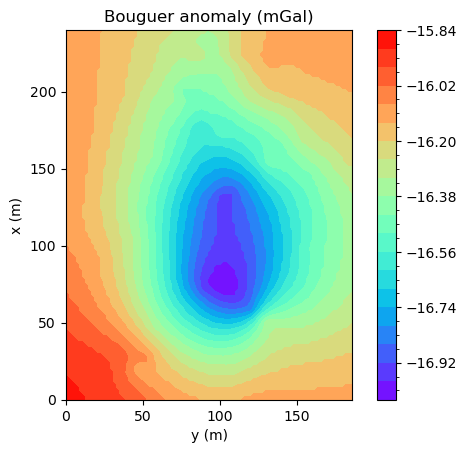

In [266]:
fig, ax = plt.subplots(1, 1)

c = ax.contourf(Y, X, DATA, levels=20, cmap="rainbow")
cbar = fig.colorbar(c, ax=ax, extend="both")
ax.ticklabel_format(style="plain", scilimits=(0, 10), useOffset=False)
cbar.minorticks_on()
ax.set_aspect("equal", "box")
ax.set_xlabel("y (m)")
ax.set_ylabel("x (m)")
ax.set_title("Bouguer anomaly (mGal)")

# 2 Anomaly Isolation

Anomaly isolation divides the anomaly into a residual anomaly and a regional anomaly. We assume the regional anomaly is caused by some larger/deeper regional structures and the residual anomaly is caused by the geological structures of intrest.



For the details of the methods, refer to the following book chapter:
- *Hinze WJ, von Frese RRB, Saad AH. Appendix A Data systems processing. In: Gravity and Magnetic Exploration: Principles, Practices, and Applications. Cambridge University Press; 2013:422-476.*

## 2.1 Method 1: Trend surface analysis (detrending)

This method uses a polynomial to approximate the regional anomaly, also known as trend surface. Subtracting the trend from the anomaly, we can get the residual anomaly (局部异常).

Let's use a bilinear polynomial $g_{trend}=a_1+a_2x+a_3y+a_4xy$ as the trend surface.

$$\mathbf{g}_{trend}=\left(
    \begin{array}{cccc}
    1&x_1&y_1&x_1y_1\\
    \vdots&\vdots&\vdots&\vdots\\
    1&x_n&y_n&x_Ny_n\\
    \end{array}
    \right)
    \left(
    \begin{array}{c}
    a_1\\a_2\\a_3\\a_4
    \end{array}
    \right)=\mathbf{C}\mathbf{a}$$
where $\mathbf{a}=(a_1,a_2,a_3,a_4)^T$ are the unknown parameters.

We can get the parameters $\mathbf{a}$ by solving
$$\argmin \|\mathbf{\mathbf{C}\mathbf{a}-\mathbf{d}_{obs}}\|_2^2$$

which is equivalent to solving the system of equations 
$$(\mathbf{C}^T\mathbf{C})\mathbf{a}=\mathbf{C}^T\mathbf{d}_{obs}$$

In [267]:
# reshape the coodinates and the data from matrices into vectors
xx = X.flatten()
yy = Y.flatten()
dd = DATA.flatten()

# construct the coefficent matrix
C = np.zeros((len(dd), 4))
C[:, 0] = 1
C[:, 1] = xx
C[:, 2] = yy
C[:, 3] = xx * yy

# solve the system of equations C^T C a=C^T d
a = sp.linalg.solve(C.T @ C, C.T @ dd)
print(a)

[-1.61292596e+01 -8.68911674e-04 -2.52452205e-03  1.00915745e-05]


In [268]:
def cal_bilinear_trend(a, x, y):
    return a[0] + a[1] * x + a[2] * y + a[3] * x * y


# calculate the trend surface using the parameters
DATA_trend = cal_bilinear_trend(a, X, Y)

# Subtract the trend from the total anomaly to get the residual anomaly
DATA_detrend = DATA - DATA_trend

Text(0.5, 1.0, 'Residual anomaly')

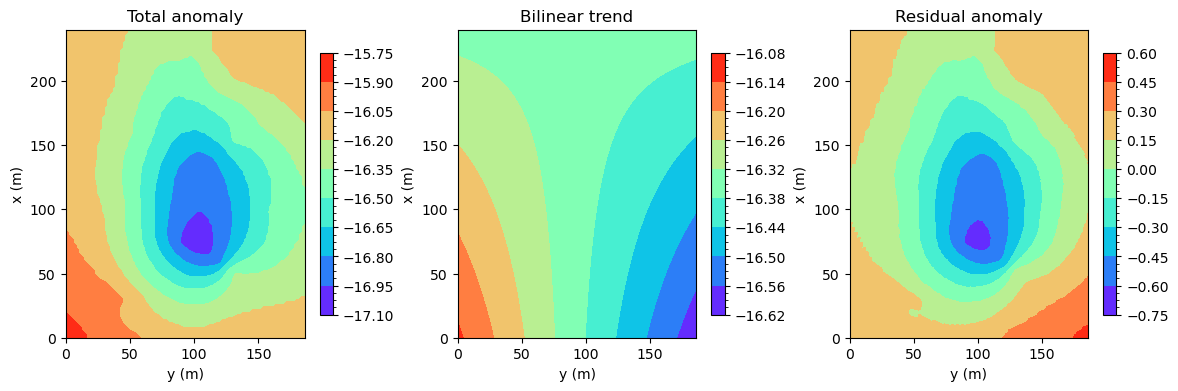

In [269]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.3)
for i, D in enumerate([DATA, DATA_trend, DATA_detrend]):
    ax = axs[i]
    c = ax.contourf(Y, X, D, cmap="rainbow")
    cbar = fig.colorbar(c, ax=ax, shrink=0.85)
    cbar.minorticks_on()

for ax in axs:
    ax.set_aspect("equal", "box")
    ax.set_xlabel("y (m)")
    ax.set_ylabel("x (m)")

axs[0].set_title("Total anomaly")
axs[1].set_title("Bilinear trend")
axs[2].set_title("Residual anomaly")

We can also show it in a 3D view:

Text(0.5, 0.92, 'Residual anomaly')

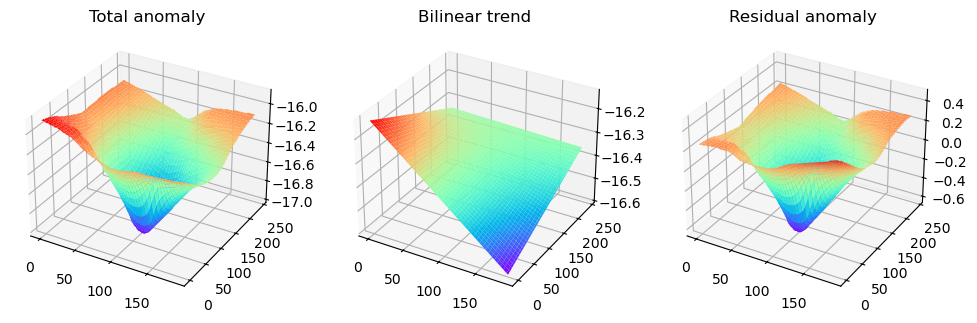

In [270]:
fig, axs = plt.subplots(1, 3, figsize=(12, 8), subplot_kw={"projection": "3d"})
c = axs[0].plot_surface(Y, X, DATA, cmap="rainbow")
c2 = axs[1].plot_surface(Y, X, DATA_trend, cmap="rainbow")
c3 = axs[2].plot_surface(Y, X, DATA_detrend, cmap="rainbow")
axs[0].set_title("Total anomaly")
axs[1].set_title("Bilinear trend")
axs[2].set_title("Residual anomaly")

## 2.2 Method 2: Spectral filtering

In [271]:
SP = sp.fft.fft2(DATA)
SP = fftshift(SP)

dx = x[1] - x[0]
dy = y[1] - y[0]
xf = fftfreq(nx, dx)
yf = fftfreq(ny, dy)
# we have swapped x and y, and now x points to the north, y points to the east. When plotting a figure, we consider the new y (east) as x-axis in the figure and the new x (north) as y-axis in the figure
YF, XF = np.meshgrid(yf, xf)
XF = fftshift(XF)
YF = fftshift(YF)

Show the 2D spectrum of the original Bouguer anomay

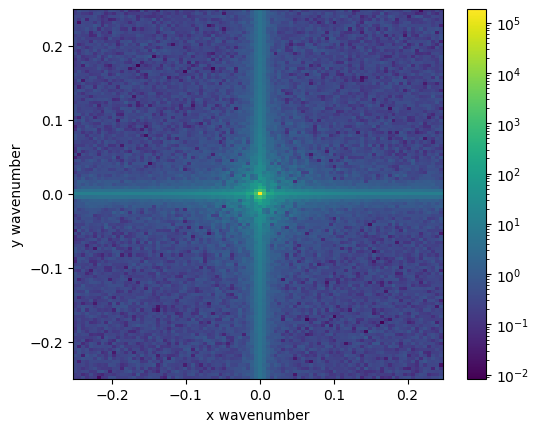

In [272]:
fig, ax = plt.subplots(1, 1)
Z = np.abs(SP)
c = ax.pcolormesh(YF, XF, Z, norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(c, ax=ax)
ax.set_xlabel("x wavenumber")
ax.set_ylabel("y wavenumber")
ax.set_aspect("equal", "box")

Make a filter in frequency domain

In [273]:
# Reference: https://newion.uwinnipeg.ca/~sliao/Courses/7205/Week07A.pdf


# filters formed by rotating a boxcar window. This filter is susceptible to Gibbs’ error.
def circular_lowpass_window(f_cut, XF, YF):
    temp = np.zeros_like(XF)
    mask = (XF**2 + YF**2) <= (f_cut**2)
    temp[mask] = 1
    return temp


def circular_banpass_window(freqmin, freqmax, XF, YF):
    temp = np.zeros_like(XF)
    mask = ((XF**2 + YF**2) >= (freqmin**2)) & ((XF**2 + YF**2) <= (freqmax**2))
    temp[mask] = 1
    return temp


# Filters with window carpentry.
# A larger n results a sharper window edge.
# Sharper windows can cause larger Gibbs’ errors, while smoother windows retain more signal energy in the rejected band.
def Butterworth_lowpass_window(f_cut, XF, YF, n=4):
    D = np.sqrt(XF**2 + YF**2)
    temp = 1 / (1 + (D / f_cut) ** (2 * n))
    return temp


def Butterworth_bandpass_window(freqmin, freqmax, XF, YF, n=4):
    D = np.sqrt(XF**2 + YF**2)
    temp1 = 1 / (1 + (D / freqmax) ** (2 * n))
    temp2 = 1 - 1 / (1 + (D / freqmin) ** (2 * n))
    return temp1 * temp2

Text(0.5, 0, 'x wavenumber')

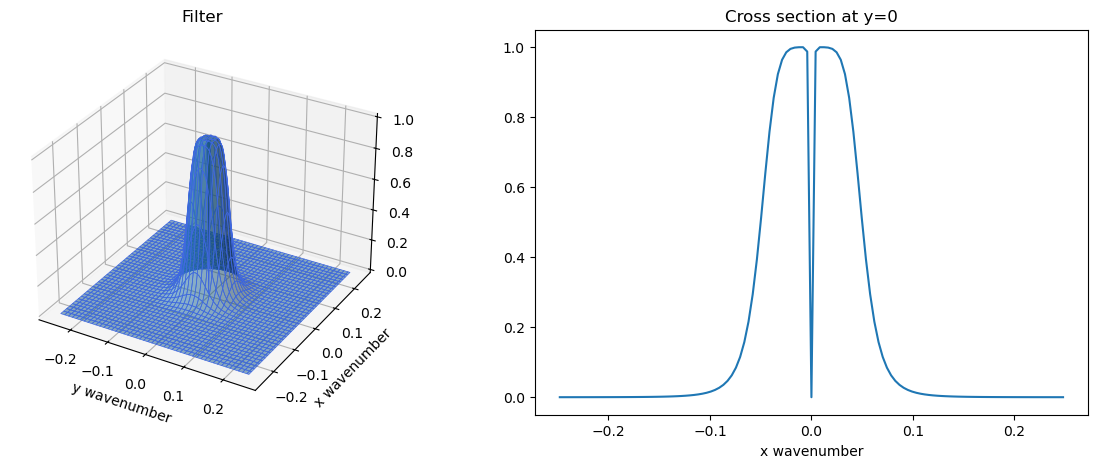

In [274]:
# You can try different valuse of n to see how the shape of the window changes

filter_win = Butterworth_bandpass_window(
    freqmin=1 / 500, freqmax=1 / 20, XF=XF, YF=YF, n=3
)
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")

surf = ax1.plot_surface(
    YF,
    XF,
    filter_win,
    linewidth=0,
    antialiased=True,
    edgecolor="royalblue",
    lw=0.5,
    alpha=0.5,
)
ax1.set_xlabel("y wavenumber")
ax1.set_ylabel("x wavenumber")
ax1.set_title("Filter")

ax2 = fig.add_subplot(1, 2, 2)
plt.subplots_adjust(wspace=0.1)
ax2.plot(XF[np.isclose(YF, 0)], filter_win[np.isclose(YF, 0)])
ax2.set_title("Cross section at y=0")
ax2.set_xlabel("x wavenumber")

Apply the filter to the data

In [275]:
# Apply the filter
SP_pass = SP * filter_win
SP_reject = SP * (1 - filter_win)

# Convert the filtered signal from spectral domain to spatial domain
DATA_pass = ifft2(ifftshift(SP_pass)).real
DATA_reject = ifft2(ifftshift(SP_reject)).real

Text(0.5, 1.0, 'Passed signal')

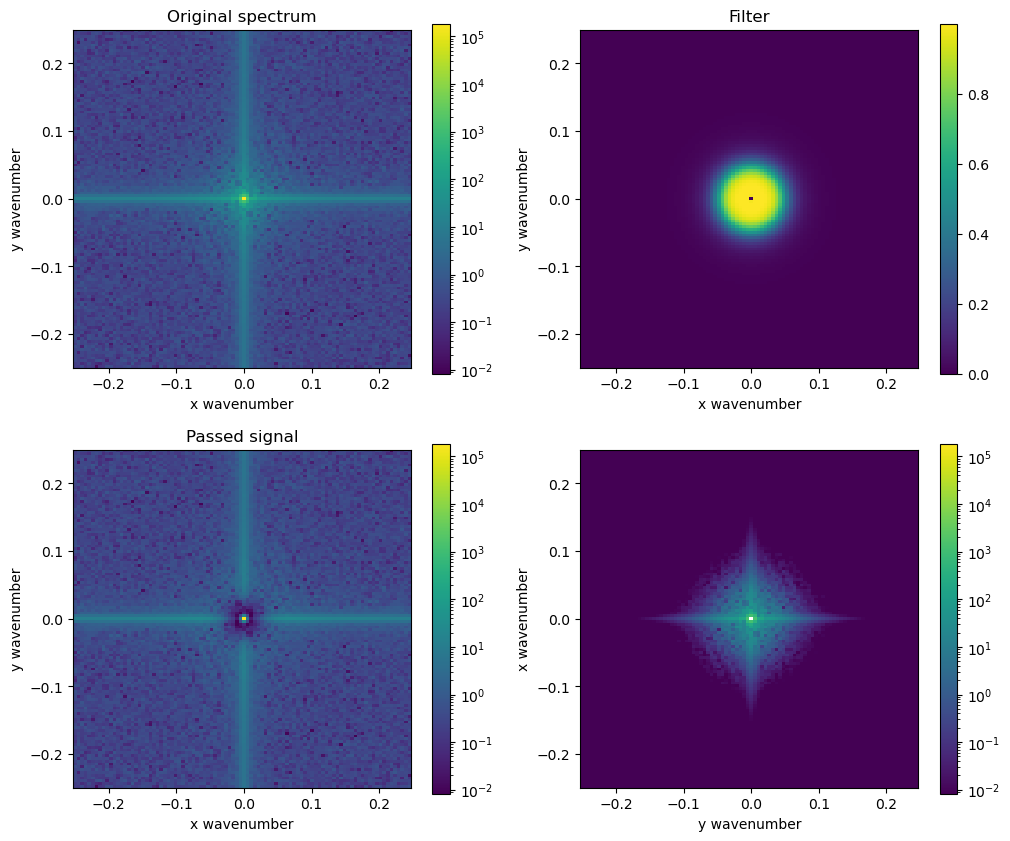

In [276]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

c = axs[0][0].pcolormesh(YF, XF, np.abs(SP), norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
fig.colorbar(c, ax=axs[0][0])
axs[0][0].set_xlabel("x wavenumber")
axs[0][0].set_ylabel("y wavenumber")
axs[0][0].set_aspect("equal", "box")
axs[0][0].set_title("Original spectrum")

c = axs[0][1].pcolormesh(YF, XF, filter_win)
fig.colorbar(c, ax=axs[0][1])
axs[0][1].set_xlabel("x wavenumber")
axs[0][1].set_ylabel("y wavenumber")
axs[0][1].set_aspect("equal", "box")
axs[0][1].set_title("Filter")

c = axs[1][0].pcolormesh(
    YF, XF, np.abs(SP_reject), norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)
fig.colorbar(c, ax=axs[1][0])
axs[1][0].set_xlabel("x wavenumber")
axs[1][0].set_ylabel("y wavenumber")
axs[1][0].set_aspect("equal", "box")
axs[1][0].set_title("Rejected signal")

c = axs[1][1].pcolormesh(
    YF, XF, np.abs(SP_pass), norm=LogNorm(vmin=Z.min(), vmax=Z.max())
)
fig.colorbar(c, ax=axs[1][1])
axs[1][1].set_xlabel("y wavenumber")
axs[1][1].set_ylabel("x wavenumber")
axs[1][1].set_aspect("equal", "box")
axs[1][0].set_title("Passed signal")

Text(0.5, 1.0, 'Residual anomaly \n(signal in the passband)')

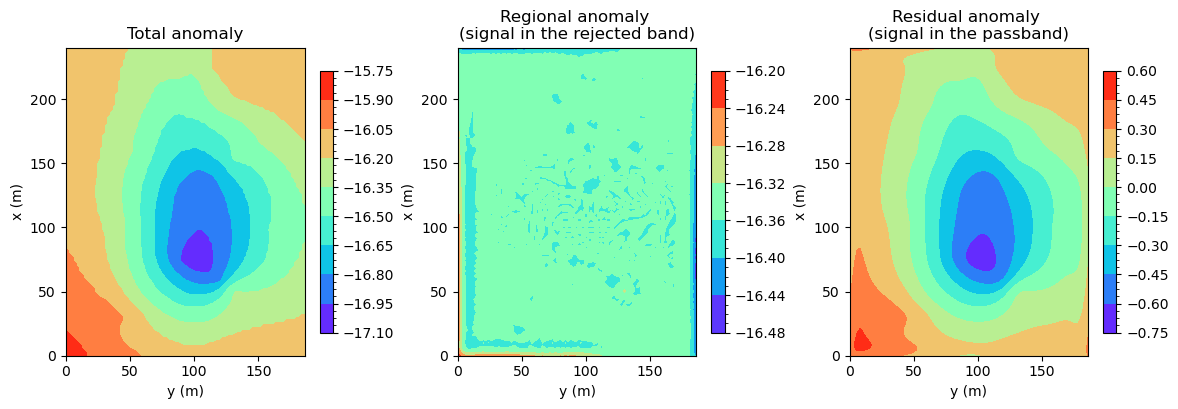

In [277]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.3)
for i, D in enumerate([DATA, DATA_reject, DATA_pass]):
    ax = axs[i]
    c = ax.contourf(Y, X, D, cmap="rainbow")
    cbar = fig.colorbar(c, ax=ax, shrink=0.85)
    cbar.minorticks_on()

for ax in axs:
    ax.set_aspect("equal", "box")
    ax.set_xlabel("y (m)")
    ax.set_ylabel("x (m)")
axs[0].set_title("Total anomaly")
axs[1].set_title("Regional anomaly \n(signal in the rejected band)")
axs[2].set_title("Residual anomaly \n(signal in the passband)")

# 3 Save the results

Save the detrended anomaly

In [278]:
xx = X.flatten()
yy = Y.flatten()
dd = DATA_detrend.flatten()
data_to_save = np.stack((xx, yy, dd)).T
np.savetxt("Detrended_anomaly.dat", data_to_save)

Save the filtered anomaly

In [279]:
xx = X.flatten()
yy = Y.flatten()
dd = DATA_pass.flatten()
data_to_save = np.stack((xx, yy, dd)).T
np.savetxt("Filtered_anomaly.dat", data_to_save)

In [280]:
x_read, y_read, d_read = np.loadtxt("Filtered_anomaly.dat", unpack=True)

In [281]:
X = x_read.reshape((nx, ny))
Y = y_read.reshape((nx, ny))
D = d_read.reshape((nx, ny))

In [282]:
X

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  2.,   2.,   2., ...,   2.,   2.,   2.],
       [  4.,   4.,   4., ...,   4.,   4.,   4.],
       ...,
       [236., 236., 236., ..., 236., 236., 236.],
       [238., 238., 238., ..., 238., 238., 238.],
       [240., 240., 240., ..., 240., 240., 240.]], shape=(121, 94))

In [283]:
Y

array([[  0.,   2.,   4., ..., 182., 184., 186.],
       [  0.,   2.,   4., ..., 182., 184., 186.],
       [  0.,   2.,   4., ..., 182., 184., 186.],
       ...,
       [  0.,   2.,   4., ..., 182., 184., 186.],
       [  0.,   2.,   4., ..., 182., 184., 186.],
       [  0.,   2.,   4., ..., 182., 184., 186.]], shape=(121, 94))

In [284]:
D

array([[0.33222395, 0.35709982, 0.37446326, ..., 0.25683266, 0.27725436,
        0.30376956],
       [0.35248366, 0.38510898, 0.40846295, ..., 0.25506953, 0.28136753,
        0.31557489],
       [0.36639154, 0.40518564, 0.43331848, ..., 0.25141341, 0.28242323,
        0.32276973],
       ...,
       [0.26990451, 0.27358269, 0.27455066, ..., 0.25464417, 0.25902854,
        0.26455082],
       [0.28690345, 0.2961006 , 0.30135335, ..., 0.25597541, 0.26456606,
        0.2755587 ],
       [0.30883897, 0.32543289, 0.33641136, ..., 0.25694436, 0.27112629,
        0.28943845]], shape=(121, 94))

Text(0, 0.5, 'x (north, m)')

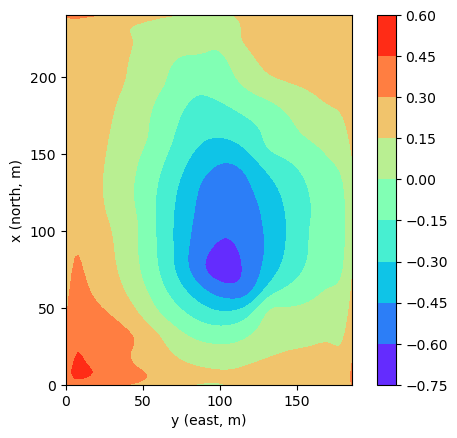

In [287]:
fig, ax = plt.subplots(1, 1)
c = ax.contourf(Y, X, D, cmap="rainbow")
plt.colorbar(c)
ax.set_aspect("equal", "box")
ax.set_xlabel("y (east, m)")
ax.set_ylabel("x (north, m)")